<a href="https://colab.research.google.com/github/RoaldKhairov/skill_project/blob/master/rfm_cookbook/RFM_segment_cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Пример сегментации покупателей по RFM

In [39]:
# id гугл диска
! gdown --id 1nlDRXQAtI7OoXs_YPAWG2qEO6Fs0r_fI

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1nlDRXQAtI7OoXs_YPAWG2qEO6Fs0r_fI
To: /content/OnlineRetail.csv
100% 45.6M/45.6M [00:00<00:00, 160MB/s]


In [40]:
import pandas as pd 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
path = '/content/OnlineRetail.csv'
df = pd.read_csv(path, encoding='latin1')

In [4]:
# Данные
print(df.head(1))
print('------------------------------------------')
print(df.describe())
print('------------------------------------------')
print(df.info())

  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
------------------------------------------
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   ----- 

In [5]:
# Чистка данных
df = df[df['CustomerID'].notna()]
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [6]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"] = df["InvoiceDate"].dt.date

In [7]:
# Create TotalSum colummn
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

# Create date variable that records recency
snapshot_date = max(df["InvoiceDate"]) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [8]:
customers.head(5)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


### RFM сегменты

In [9]:
# Чем меньше давность, тем лучше. 
r_labels = range(4, 0, -1)

# Деньги и частотность наоборот.
f_labels = range(1, 5)
m_labels = range(1, 5)

# Разобьем сегменты тупо по квартилям (вообще лучше по бизнес задаче это делать)
r_quartiles = pd.qcut(customers['Recency'], 4, labels = r_labels)
f_quartiles = pd.qcut(customers['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(customers['MonetaryValue'], 4, labels = m_labels)


customers = customers.assign(F = f_quartiles.values)
customers = customers.assign(M = m_quartiles.values)
customers = customers.assign(R = r_quartiles.values)

customers.head()

,Recency,Frequency,MonetaryValue,F,M,R
CustomerID,,,,,,
12346.0,326,1,77183.60,1,4,1
12347.0,3,182,4310.00,4,4,4
12348.0,76,31,1797.24,2,4,2
12349.0,19,73,1757.55,3,4,3
12350.0,311,17,334.40,1,2,1


In [10]:
# Посчитаем score и выделим сегменты

customers['RFM_Segment'] = customers['R'].astype(str) + customers['F'].astype(str) + customers['M'].astype(str)
customers['RFM_Score'] = customers[['R', 'F', 'M']].sum(axis = 1)

In [11]:
# Подчет сегментов
customers.groupby('RFM_Segment').size().sort_values(ascending = False)[:15]

RFM_Segment
444    440
111    385
344    222
122    206
211    181
233    169
333    168
222    165
433    148
322    126
311    123
112    104
244    103
121    100
223     91
dtype: int64

In [12]:
# Подчет сегментов по score
customers.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count', 'sum']
}).round(1)

Recency Frequency MonetaryValue                 
             mean      mean          mean count        sum
RFM_Score                                                 
3           261.4       8.2         159.3   385    61334.4
4           175.2      13.7         239.0   385    92018.4
5           154.3      21.4         368.7   517   190602.3
6            96.6      28.0         823.8   464   382239.9
7            80.3      38.7         760.4   452   343681.5
8            64.7      57.0         994.1   459   456306.3
9            46.6      80.1        1810.7   413   747809.6
10           32.6     112.7        2058.3   428   880951.0
11           21.4     188.0        4071.8   395  1608346.5
12            7.6     377.7        9427.5   440  4148118.1

In [13]:
def segment_me(df):
  '''Обзовем сегменты'''

  if df['RFM_Score'] >= 9:
    return 'Whales'
  elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
    return 'Dolphins'
  else:
    return 'Fish'

# Итоговые названия сегментов
customers['General_Segment'] = customers.apply(segment_me, axis = 1)

# Статистика по сегментам
customers.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Dolphins          100.7      35.8         725.6  1892
Fish              218.3      11.0         199.2   770
Whales             26.9     192.0        4406.5  1676

### Кластеризация как альтернатива RFM

Класстеризацию предпочтительно проводить на стандартизованных данных, а для стандартизации данных предпочтительно нормальное распределение. 



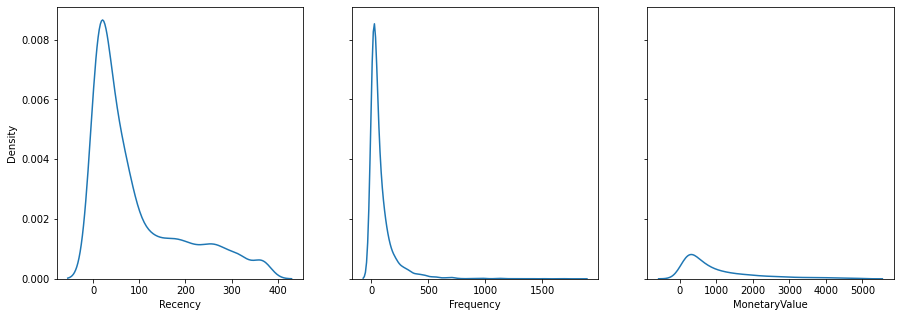

In [18]:
#Посмотрим распределение данных

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.kdeplot(data=customers, x = 'Recency', ax=axes[0])
sns.kdeplot(data=customers[customers['Frequency'] < 2000], x = 'Frequency', ax=axes[1])
sns.kdeplot(data=customers[customers['MonetaryValue'] < 5000], x = 'MonetaryValue', ax=axes[2])

Распределения ассиметричны, но можно использовать метод Бокса-Кокса для преоброзавания (альтернативно можно использовать логарифмирование, брать в квадрат и пр. нужно брать ту, где ассиметрия ближе к 0)

In [15]:
customers["Recency_fix"] = stats.boxcox(customers['Recency'])[0] 
customers["Frequency_fix"] = stats.boxcox(customers['Frequency']) [0] 
customers["MonetaryValue_fix"] = stats.boxcox(customers['MonetaryValue'])[0]

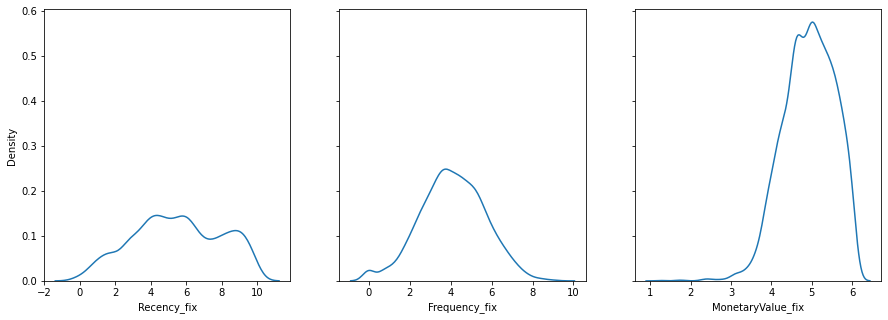

In [20]:
#Посмотрим распределение  преобразованных данных

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.kdeplot(data=customers, x = 'Recency_fix', ax=axes[0])
sns.kdeplot(data=customers[['Frequency'] < 2000], x = 'Frequency_fix', ax=axes[1])
sns.kdeplot(data=customers[customers['MonetaryValue'] < 5000], x = 'MonetaryValue_fix', ax=axes[2])

In [23]:
# Коэффициент ассиметрии
customers.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Recency               1.245826
Frequency            18.106165
MonetaryValue        19.324953
RFM_Segment          -0.010092
RFM_Score             0.043305
Recency_fix          -0.063372
Frequency_fix         0.004135
MonetaryValue_fix    -0.015831
dtype: float64

Ну такое, но норм. Теперь нормализуем данные для сопоставления разных переменных. 

In [29]:
# Функция в переменной
scaler = StandardScaler()

# Стандартизация
scaler.fit(customers[['Recency_fix', 'Frequency_fix', 'MonetaryValue_fix']])
customers_normalized = scaler.transform(customers[['Recency_fix', 'Frequency_fix', 'MonetaryValue_fix']])

Чтобы сделать сегментацию данных, мы можем использовать алгоритм K-Means.
Для определения числа кластеров можем использовать метод локтя (где сумма квадратов ошибок внутри кластеров (SSE) минимальная).  

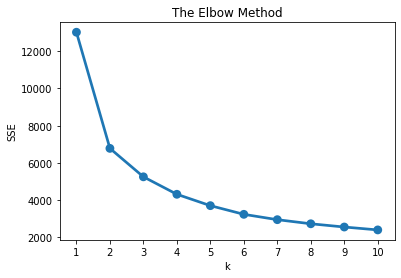

In [31]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

После третьего кластера, значение SSE приобритает линейный тренд. Следовательно, возьмем три кластера.

In [32]:
model = KMeans(n_clusters=3)
model.fit(customers_normalized)
model.labels_.shape

(4338,)

#### Интерпретация

In [33]:
# Статистика по кластерам
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         65.69     51.53        975.78  1811
1        192.58     15.46        284.79  1353
2         20.59    241.60       5757.19  1174

Получилось три класстера: 

1. Середняки
2. Слабаки
3. Силачи



In [35]:
# Статистика по RFM кластерам
customers.groupby('General_Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Dolphins         100.74     35.78        725.60  1892
Fish             218.26     10.96        199.16   770
Whales            26.87    191.98       4406.46  1676

Что даже похоже на кластеры, которые мы выделили в рамках RFM анализа.

Для наглядности сделаем график изменения характеристик в зависимости от кластера.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positio

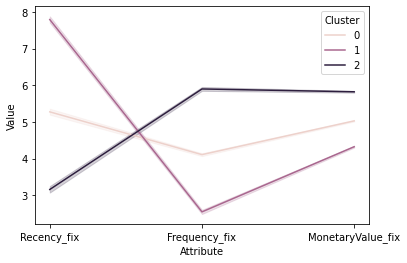

In [38]:
# Сделаем отдельный набор данных
df_normalized = customers[['Recency_fix', 'Frequency_fix', 'MonetaryValue_fix']]
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

# Распивотим данные
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency_fix','Frequency_fix','MonetaryValue_fix'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

# Картинка
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

**Вывод**

Теперь мы знаем, чем отличается каждый сегмент.

Кластер 1 (0 на графике) встречается часто, тратит средне, был относительно давно. Следовательно, это может быть потенциально уходящих клиентов.

Кластер 2 (1) покупал давно, покупок и выручки с них мало. Следовательно, это может быть кластер ушедших клиентов .

Наконец, группа 3 (2). Покупала недавно, тратит много и часто. Лояльные клиенты.